In [24]:
#https://cloud.google.com/bigquery/docs/reference/libraries?hl=es-419#client-libraries-install-python
# !pip install google-cloud
# !pip install --upgrade google-cloud-bigquery
# !pip install db-dtypes

--------
# Challenge

Se espera que muestren conocimiento en las siguientes areas:

- Realizar consultas a una base de datos publica alojada en Google Could Plataform
- Trabajar con bases de datos relacionales
- Procesamiento de datos
- Visualización de datos
- Versionado de software

Usando el dataset `nhtsa_traffic_fatalities` desde el proyecto `bigquery-public-data`, y usando la tabla de datos del año 2015. Se pide realizar lo siguiente:

1. Crear y completar un diccionario de datos de la tabla, guardarlo en un archivo de texto separado por comas `.csv` 
Lo siguiente se debe realizar en un jupyter notebook
2. Identificar, usando consultas y con gráficas las siguientes características del dataset: 
   1. Mayor numero de accidentes por estado (`state_name`).
   2. Mayor numero de accidentes por uso de tierra (`land_use_name`).
   3. Mayor numero de accidentes por empresa de carreteras (`ownership_name`).
   4. Mayor numero de accidentes por carretera (`trafficway_identifier`).
3. Realizar un análisis mensual de accidentes por estado. 
4. Realizar un análisis según la hora del dia. 
   - Ahondar para los estados con mayor cantidad de muertes
5. Finalmente realizar un análisis resaltando la razón entre números de accidentes y conductores ebrios. 

Los resultados deben ser entregados como un repositorio en [github](https://github.com), con una rama de desarrollo  y una de producción, además el repositorio deberá contar con un archivo de requerimientos (requirements.txt) donde se listen las librerías de python relevantes para el desarrollo del análisis y un readme donde se presenten los resultados obtenidos indicando y argumentando todos los descubrimientos que realicen del dataset. 

Para realizar el trabajo en github, les recomiendo la siguiente [guía](https://david-estevez.gitbooks.io/the-git-the-bad-and-the-ugly/content/es/buenas-practicas-al-trabajar-con-git.html), si van a trabajar en grupos, ademas de especificarlo en el readme, cada integrante debe tener su rama de desarrollo y hacer los correspondiente fork y pull request.

Siguiendo las instrucciones de  https://cloud.google.com/docs/authentication/provide-credentials-adc?hl=es-419

- gcloud init
- gcloud auth application-default login

---
## Importing libraries

In [25]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# Task 1 :  Analysis per hour
-----
-----
-----

## The BigQuery

In [26]:

#DATABASE 'bigquery-public-data.nhtsa_traffic_fatalities.accident_2015'
def querydesaf(column,timeunit):
      client = bigquery.Client()
      qq2 ="""
        SELECT {},                                                                   --selecting the desired feature
        COUNT(consecutive_number) AS num_accidents,                                  --counting the number of accidents by their ID (consecutive_number)
        EXTRACT({} FROM timestamp_of_crash) AS {},                               --Extracting the hour of the accident
        FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`           --calling the bigquery data base
        
        WHERE {} IN (                                                                --WHERE usual sintax is  => WHERE IN (A,B,C) so the SELECT in the following line have to be the same kind of data
              SELECT {},                                                             --select the desired feature to match in the argument in WHERE
              FROM (                                                                 --from a new table created by us 
              SELECT {},                                                             --select the desired feature 
              SUM(number_of_fatalities) AS tot                                       --aggregat with a SUM all the fatalities and store them in tot
              FROM  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`    --calling the main  bigquery data base
              GROUP BY {}                                                            --since we did a SUM above is mandatory to group by the other feature selected, in this case just the other
              ORDER BY tot DESC                                                      --descending order because we want to  extract the first 10 cases
              LIMIT 10                                                               --truncate the new table to the first 10 cases
              )                
        )
        GROUP BY  {}, {}                                                           --group by the desired feature and hour
        ORDER BY  {}, {};                                                          --sort the result
        """.format(column,timeunit,timeunit.lower(),column,column,column,column,column,timeunit.lower(),column,timeunit.lower())
      query_job = client.query(qq2)  # Make an API request.
      results = query_job.result()
      df = results.to_dataframe()
      df = df.sort_values(by=['{}'.format(column),'num_accidents'],ascending=False).reset_index()
      # display(df)
      return df

**Creation of a function to sort and plot**


In [27]:
def extract_data(feature,timeunit = 'HOUR'):
    """
    Feature =  is the feature desired followung the one in the query in the previous cell.
    """
    df2        = querydesaf(feature,timeunit)
    df_aux     = pd.DataFrame(df2.groupby([feature])['num_accidents'].agg(max)).reset_index()  #grouping the data set by feature

    # matching the result df from the query and the grouped one and droping unnecesary columns
    df_final = pd.merge(df_aux,df2,how='left',sort=True).drop_duplicates(subset=feature).sort_values('num_accidents',ascending=False).reset_index().drop(['level_0','index'],axis=1) 
    
    df_final = df_final.set_index(feature)
    
    display(df_final.T)
    
    return df_final, df2

def my_plot(df):
    ##################################################
    ##################################################PLOTING
    ##################################################
    fig, ax  = plt.subplots(figsize=(15,7.5))
    sns.barplot(data=df, x=df.index, y = 'num_accidents', ax=ax)
    ax.set_xticklabels(df.index,rotation=45,fontdict={'horizontalalignment':'right'})
    # plt.close(fig)
    
    

## For STATE_NAME

state_name,California,Florida,Texas,Georgia,North Carolina,New York,Pennsylvania,Ohio,Illinois,South Carolina
num_accidents,208,201,196,86,81,79,72,70,61,59
hour,20,20,21,21,19,17,15,16,13,18


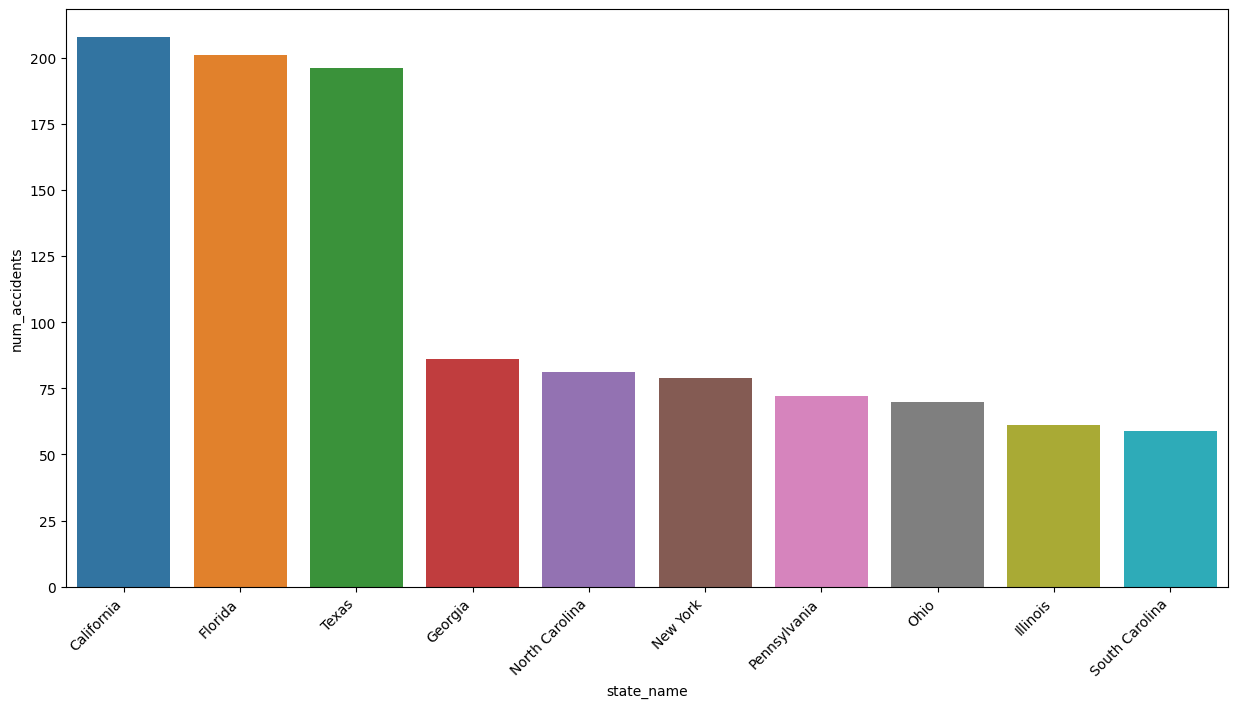

In [28]:
target         = 'state_name'
tu             = 'HOUR'
df, df_orig    = extract_data(target,timeunit=tu)
my_plot(df)

df.to_csv(target+'_num_fatalities_per_{}.csv'.format(tu.lower()))

**Cross checking the results**

In the following cell I extract one of the features and check its maxima in the first row

In [29]:
check ='California'
display('Checking for {} = {} feature'.format(target,check),df_orig[df_orig[target]=='California'].sort_values('num_accidents',ascending=False).head(5))

'Checking for state_name = California feature'

,index,state_name,num_accidents,hour
216,20,California,208,20
217,18,California,204,18
218,21,California,187,21
219,0,California,185,0
220,19,California,171,19


---
## For Land_use_name

land_use_name,Urban,Rural,Trafficway Not in State Inventory,Unknown,Not Reported
num_accidents,1072,975,16,4,2
hour,20,17,18,0,2


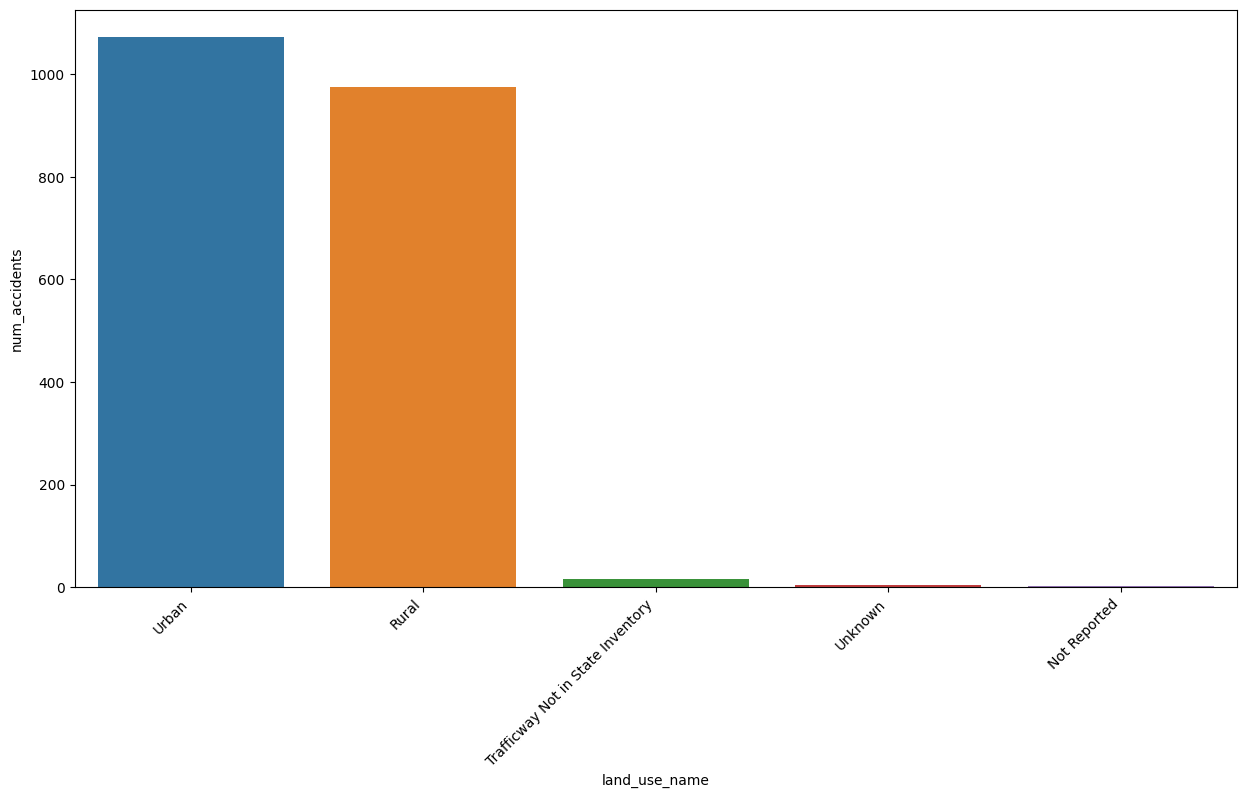

In [30]:
target         = 'land_use_name'
tu             = 'HOUR'
df, df_orig    = extract_data(target,timeunit=tu)
my_plot(df)
df.to_csv(target+'_num_fatalities_per_{}.csv'.format(tu.lower()))

---
## For ownership_name

ownership_name,State Highway Agency,Not Reported,County Highway Agency,City or Municipal Highway Agency,Unknown,Town or Township Highway Agency,Other Local Agency,Trafficway Not in State Inventory,State Toll Road,Other Federal Agency
num_accidents,893,415,229,212,77,72,51,16,6,5
hour,17,21,18,20,21,17,20,18,3,8


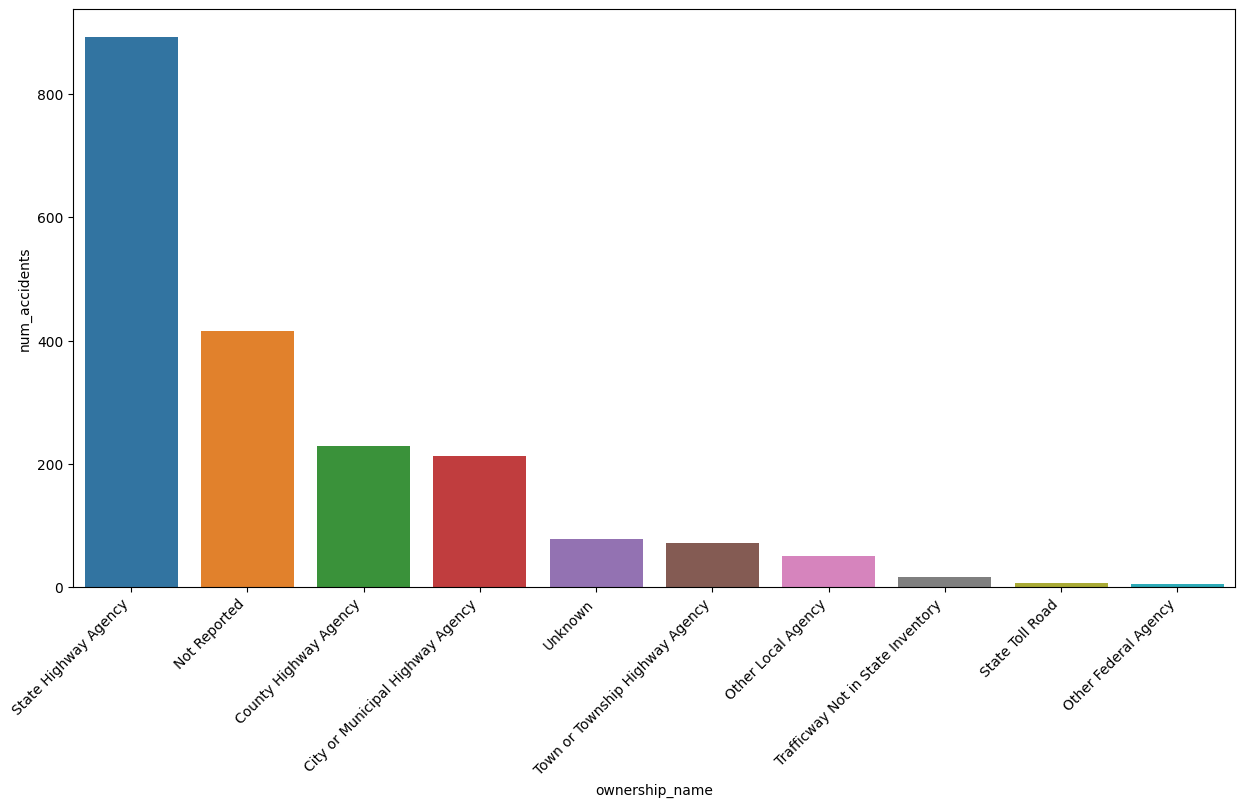

In [31]:
target         = 'ownership_name'
tu             = 'HOUR'
df, df_orig    = extract_data(target,timeunit='HOUR')
my_plot(df)
df.to_csv(target+'_num_fatalities_per_{}.csv'.format(tu.lower()))

---
## For trafficway_identifier

trafficway_identifier,I-10,US-1,I-75,I-95,I-20,I-40,I-70,I-5,I-15,I-80
num_accidents,21,18,16,15,13,13,12,11,10,9
hour,1,22,3,13,22,14,2,2,0,11


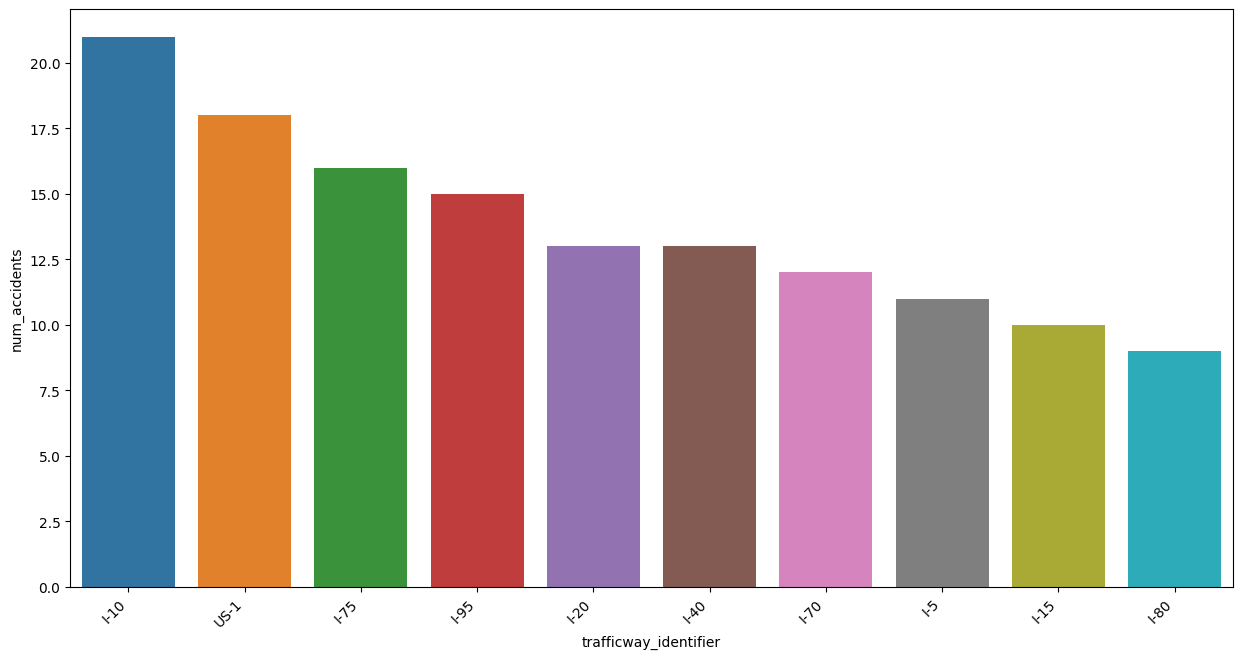

In [32]:
target         = 'trafficway_identifier'
tu             = 'HOUR'
df, df_orig    =  extract_data(target,timeunit=tu)
my_plot(df)
df.to_csv(target+'_num_fatalities_per_{}.csv'.format(tu.lower()))

---
---
---
# TASK 2 : Analysis per month


state_name,Texas,California,Florida,Georgia,North Carolina,Ohio,New York,Pennsylvania,South Carolina,Illinois
num_accidents,319,295,293,137,132,132,121,112,110,92
month,10,12,12,10,5,8,5,7,10,6


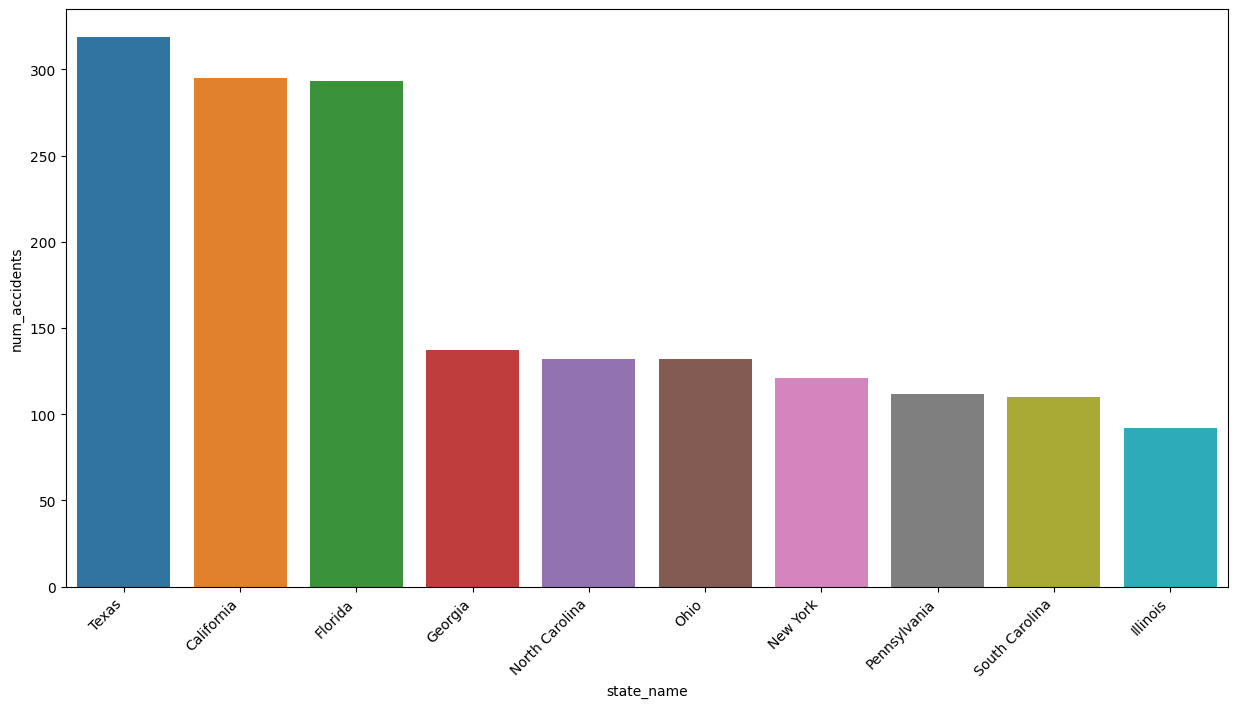

In [33]:
target         = 'state_name'
tu             = 'MONTH'
df, df_orig    =  extract_data(target,timeunit='MONTH')
my_plot(df)
df.to_csv(target+'_num_fatalities_per_{}.csv'.format(tu.lower()))

Note that when filtering by hour the first 3 bars where California-FLorida-Texas and now Texas is has the greatest value.

---
---
---
# TASK 3 : fatalities vs drunk driver: showing the percentage


Text(0.5, 0, 'ratio %')

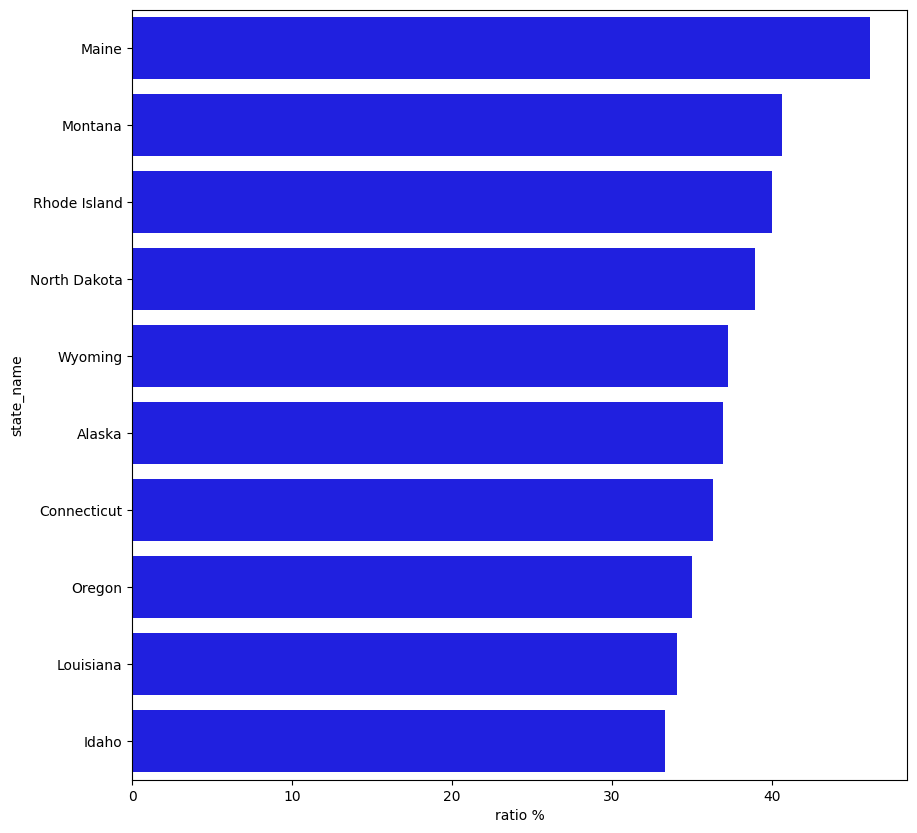

In [34]:
def querydesaf2(column):
      client = bigquery.Client()
      qq=f"""
        SELECT
              {column},
              tot_fatalities,
              tot_drunk_driv,
              ROUND((tot_drunk_driv / tot_fatalities) *100,3) AS ratio 
        FROM(
            SELECT {column},
            SUM(number_of_fatalities)      AS tot_fatalities,
            SUM(number_of_drunk_drivers)   AS tot_drunk_driv,
            FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`  
            GROUP BY {column}
            ORDER BY tot_fatalities DESC
            )
        ORDER BY ratio DESC
        LIMIT 10
        """
      query_job = client.query(qq)  # Make an API request.
      results = query_job.result()
      df = results.to_dataframe()
      # df = df.sort_values(by=['{}'.format(column),'num_accidents'],ascending=False).reset_index()
      # display(df)
      return df
df  = querydesaf2('state_name')
fig , ax2 = plt.subplots(figsize=(10,10))
sns.barplot(data =df,y='state_name',x='ratio',color='blue',ax=ax2)
ax2.set_xlabel('ratio %')
